# Analysis of Soybean Price Volatility in Madhya Pradesh from 2012 to 2024

- Code for the paper: https://arxiv.org/abs/2503.11690

In [60]:
# Import necessary libraries for the analysis

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

from arch import arch_model

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [61]:
# Function to optimize EGARCH parameters
def optimize_egarch_parameters(data, p_range, o_range, q_range):
    results = []
    best_aic = float('inf')
    best_params = None

    for p in p_range:
        for o in o_range:
            for q in q_range:
                try:
                    model = arch_model(data, vol='EGARCH', p=p, o=o, q=q)
                    fit = model.fit(disp='off')
                    results.append({'p': p, 'o': o, 'q': q, 'AIC': fit.aic})

                    if fit.aic < best_aic:
                        best_aic = fit.aic
                        best_params = {'p': p, 'o': o, 'q': q}

                except Exception as e:
                    print(f"Failed for p={p}, o={o}, q={q}: {e}")
                    continue

    results_df = pd.DataFrame(results).sort_values(by="AIC", ascending=True).reset_index(drop=True)

    return best_params, results_df

# Function for cross-correlation analysis between dependent and independent variables
def cross_correlation_analysis(series1, series2, max_lag=24):
    cross_corrs = [series1.corr(series2.shift(lag)) for lag in range(-max_lag, max_lag + 1)]
    lags = np.arange(-max_lag, max_lag + 1)
    
    plt.figure(figsize=(12, 4), facecolor='white')
    markerline, _, _ = plt.stem(lags, cross_corrs, linefmt='black', markerfmt='bo', basefmt='black')
    plt.setp(markerline, color='brown', markersize=6)
    plt.axhline(y=0, color='black', linewidth=1)
    plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
    plt.xticks(np.arange(-max_lag, max_lag + 1, step=6), fontweight="bold")
    plt.yticks(fontweight="bold")
    plt.ylim(-0.5, 0.5)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.gca().set_facecolor('white')
    plt.show()
    
    return pd.DataFrame({'Lag': lags, 'Cross-Correlation': cross_corrs})

# Function to perform Granger Causality Test
def granger_causality_test(df, cause, effect, max_lag=12):
    print(f"\nGranger Causality Test: {cause} -> {effect}")
    test_result = grangercausalitytests(df[[effect, cause]], max_lag, verbose=None)
    return test_result

# Function for hyperparameter tuning SARIMAX model
def auto_arima(y, exog=None, 
               p_range=(0,3), d_range=(0,1), q_range=(0,3), 
               P_range=(0,2), D_range=(0,1), Q_range=(0,2), 
               s=12, criterion="aic"):
    
    results = []
    best_score = np.inf
    best_cfg = None

    for order in itertools.product(range(p_range[0], p_range[1]+1),
                                   range(d_range[0], d_range[1]+1),
                                   range(q_range[0], q_range[1]+1)):
        for seasonal_order in itertools.product(range(P_range[0], P_range[1]+1),
                                                range(D_range[0], D_range[1]+1),
                                                range(Q_range[0], Q_range[1]+1),
                                                [s]):

            model = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                            exog=exog, enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False)
            score = getattr(fit, criterion)
            results.append({"order": order, "seasonal_order": seasonal_order, criterion: score})
            
            if score < best_score:
                best_score = score
                best_cfg = (order, seasonal_order)

    results_df = pd.DataFrame(results).sort_values(by=criterion, ascending=True).reset_index(drop=True)

    return {
        "best_order": best_cfg[0],
        "best_seasonal_order": best_cfg[1],
        f"best_{criterion}": best_score,
        "results_table": results_df
    }

## Reading Price and Meteorological Data

In [62]:
data = pd.read_csv("Price_Data/SOYBEAN-MODALPRICE-MONTHLY.csv")
data["Price Date"] = pd.to_datetime(data["Price Date"], format="%d-%m-%Y")

data.head()

,Price Date,Ashoknagar,Chhindwara,Dewas,Guna,Harda,Indore,Khandwa,Khargone,Mandsaur,Raisen,Rajgarh,Sagar,Sehore,Shajapur,Shivpuri,Tikamgarh,Ujjain,Vidisha
0,2012-01-01,2256.0,2247.5,2292.500000,2295.0,2121.666667,2324.666667,2285.000000,2315.0,2281.250000,2128.5,2317.250000,2221.75,2225.0,2345.600000,2280.0,2300.0,2351.5,2266.666667
1,2012-02-01,1175.0,2366.0,2446.000000,2453.0,2234.666667,2466.666667,2351.333333,2306.5,2300.000000,2150.0,2489.000000,2261.00,2352.0,2640.833333,2427.0,2405.0,2418.6,2408.333333
2,2012-03-01,2700.0,2705.0,2775.000000,2835.0,2552.333333,2832.500000,2658.500000,2700.0,2845.000000,2610.0,2720.000000,2725.00,2790.0,2070.000000,2800.0,2711.0,2850.0,2768.000000
3,2012-04-01,2995.0,3400.0,3278.333333,3328.0,3268.000000,3315.000000,3303.000000,3401.0,3400.000000,2585.0,3415.000000,3000.00,3450.0,2767.000000,3240.0,3325.0,3374.2,3263.250000
4,2012-05-01,3200.0,3014.0,3275.000000,3302.0,3140.500000,3282.500000,3100.000000,3195.5,3206.666667,3400.0,3163.333333,3200.00,3361.0,2661.666667,3363.0,3125.0,3185.0,3291.000000


In [63]:
prec_data = pd.read_csv("Met_Data/MP-Prec-Data.csv")
prec_data['Price Date'] = pd.to_datetime(prec_data['Price Date'], format='%d-%m-%Y')

prec_data.head()

,Price Date,Ashoknagar,Chhindwara,Dewas,Guna,Harda,Indore,Khandwa,Khargone,Mandsaur,Raisen,Rajgarh,Sagar,Sehore,Shajapur,Shivpuri,Tikamgarh,Ujjain,Vidisha
0,2012-01-01,12.82,10.21,0.89,12.82,2.46,0.54,4.46,1.11,1.50,9.99,5.85,11.02,1.55,2.61,23.52,18.46,0.39,5.00
1,2012-02-01,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.36,0.11,0.00,0.00
2,2012-03-01,0.08,0.26,0.00,0.08,0.01,0.00,0.00,0.00,0.00,0.57,0.01,0.40,0.01,0.01,0.13,0.17,0.00,0.18
3,2012-04-01,5.81,1.64,2.25,5.81,1.97,1.23,1.51,1.37,12.21,2.58,6.29,3.83,2.69,4.04,6.41,5.76,2.07,3.53
4,2012-05-01,4.22,4.25,19.99,4.22,13.19,22.16,11.37,19.36,18.41,4.25,8.55,3.97,12.31,10.32,7.28,4.79,22.27,6.19


In [64]:
tmax_data = pd.read_csv("Met_Data/MP-Tmax-Data.csv")
tmax_data['Price Date'] = pd.to_datetime(tmax_data['Price Date'], format='%d-%m-%Y')

tmax_data.head()

,Price Date,Ashoknagar,Chhindwara,Dewas,Guna,Harda,Indore,Khandwa,Khargone,Mandsaur,Raisen,Rajgarh,Sagar,Sehore,Shajapur,Shivpuri,Tikamgarh,Ujjain,Vidisha
0,2012-01-01,27.33,28.94,28.94,27.33,30.46,30.18,31.43,31.61,27.50,28.62,28.87,28.15,29.08,29.11,27.19,27.21,29.03,28.51
1,2012-02-01,34.69,35.27,35.72,34.69,37.00,36.55,36.78,37.56,33.33,35.55,36.00,35.12,36.15,36.11,34.17,35.28,35.01,35.48
2,2012-03-01,39.26,39.26,39.65,39.26,40.94,40.67,40.89,41.61,39.58,39.67,40.18,39.54,40.08,39.94,39.73,40.07,39.46,39.30
3,2012-04-01,41.57,41.39,42.05,41.57,43.35,42.36,43.12,43.19,41.26,42.30,42.32,42.37,42.40,42.13,42.87,43.04,41.64,41.82
4,2012-05-01,45.05,43.57,43.99,45.05,45.94,43.93,45.46,44.68,44.40,45.26,45.57,45.37,45.04,45.02,46.46,46.24,42.99,44.71


## Exploratory Data Analysis and Visualization

In [65]:
data["State_Mean"] = data.iloc[:, 1:].mean(axis=1) # mean modal price across all districts
data["State_std"] = data.iloc[:, 1:].std(axis=1) # standard deviation of modal price across all districts
data["State_Mean_LogReturns"] = np.log(data["State_Mean"]) - np.log(data["State_Mean"].shift(1)) # log returns of modal price across all districts
data["State_Mean_Squared_LogReturns"] = data["State_Mean_LogReturns"]**2

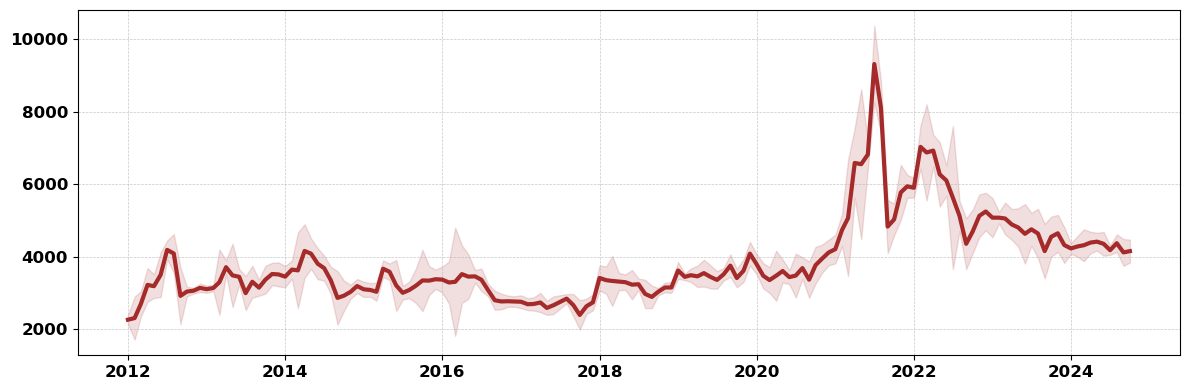

In [66]:
# Plotting the mean modal price of Soybean with standard deviation

plt.figure(figsize=(12, 4))

plt.plot(data['Price Date'], data['State_Mean'], color="brown", linewidth=3)
plt.fill_between(data['Price Date'],
                 data["State_Mean"] - 2 * data["State_std"],
                 data["State_Mean"] + 2 * data["State_std"],
                 alpha=0.15, color="brown")

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Soybean-price-MP.png", dpi=600, bbox_inches='tight')
plt.show()

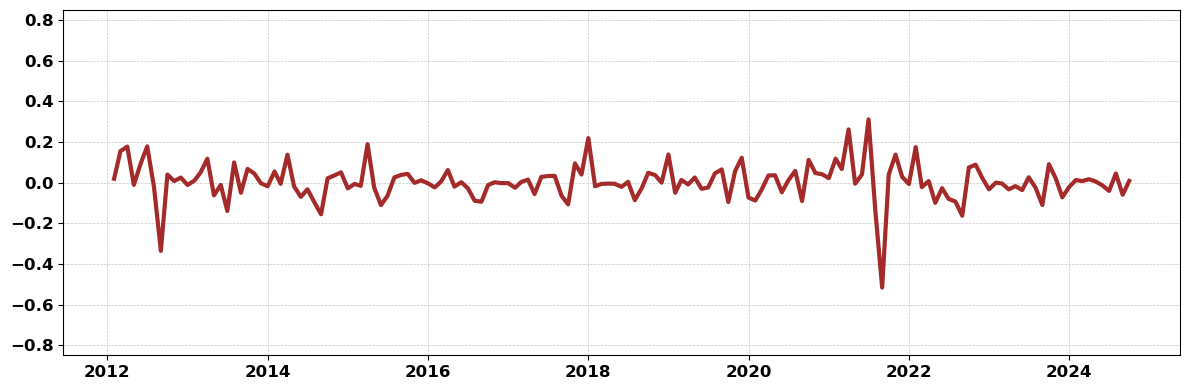

In [67]:
# Plotting the log returns of the modal price of Soybean

plt.figure(figsize=(12, 4))

plt.plot(data['Price Date'], data['State_Mean_LogReturns'], color="brown", linewidth=3)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(-0.85, 0.85)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Soybean-logreturns-MP.png", dpi=600, bbox_inches='tight')
plt.show()

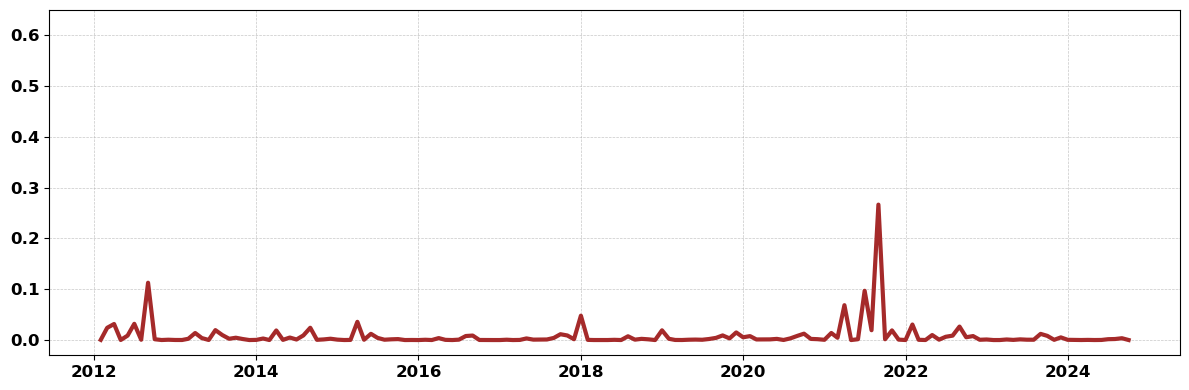

In [68]:
# Plotting the log returns of the modal price of Soybean

plt.figure(figsize=(12, 4))

plt.plot(data['Price Date'], data['State_Mean_Squared_LogReturns'], color="brown", linewidth=3)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(-0.03, 0.65)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Soybean-squared-logreturns-MP.png", dpi=600, bbox_inches='tight')
plt.show()

In [69]:
print(f"Skewness: {skew(data['State_Mean_LogReturns'].dropna())}") # skewness
print(f"Kurtosis: {kurtosis(data['State_Mean_LogReturns'].dropna())}") # kurtosis
data.describe() # descriptive statistics

Skewness: -0.9838944841385425
Kurtosis: 8.094595519761965


,Price Date,Ashoknagar,Chhindwara,Dewas,Guna,Harda,Indore,Khandwa,Khargone,Mandsaur,...,Sehore,Shajapur,Shivpuri,Tikamgarh,Ujjain,Vidisha,State_Mean,State_std,State_Mean_LogReturns,State_Mean_Squared_LogReturns
count,154,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,...,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,153.000000,1.530000e+02
mean,2018-05-17 03:44:24.935064832,3844.495346,3841.857684,3876.669790,3833.681061,3877.447727,3935.564007,3914.180118,3860.977597,3904.918579,...,3955.448289,3894.236652,3706.409236,3851.143939,3975.867089,3807.084284,3867.739029,212.863616,0.003958,8.158105e-03
min,2012-01-01 00:00:00,1175.000000,1710.000000,2292.500000,1480.000000,2121.666667,1650.000000,2285.000000,2306.500000,2230.000000,...,2000.000000,1500.000000,348.100000,2280.000000,2351.500000,2266.666667,2269.713889,40.183261,-0.516423,2.012328e-09
25%,2015-03-08 18:00:00,3102.000000,3091.125000,3141.975000,3124.875000,3110.000000,3193.750000,3151.500000,3133.916667,3183.750000,...,3190.000000,3159.514286,3045.080357,3159.375000,3185.500000,3101.125000,3154.145315,112.694385,-0.027889,2.837094e-04
50%,2018-05-16 12:00:00,3491.000000,3445.750000,3557.500000,3495.125000,3510.166667,3569.833333,3547.500000,3500.000000,3500.500000,...,3574.166667,3566.250000,3493.500000,3475.000000,3601.750000,3415.683334,3480.065223,172.173846,0.000045,1.259196e-03
75%,2021-07-24 06:00:00,4353.125000,4397.250000,4323.333333,4371.250000,4234.937500,4300.000000,4298.250000,4257.833334,4381.250000,...,4364.875000,4313.198863,4172.525000,4220.625000,4381.916667,4305.000000,4312.920784,257.205923,0.039885,6.440971e-03
max,2024-10-01 00:00:00,9877.500000,9000.000000,8880.000000,9509.000000,9297.000000,9912.500000,9517.500000,9497.000000,9716.333333,...,9454.400000,8889.333333,8042.500000,9500.000000,9760.250000,9076.400000,9312.623148,1032.369380,0.311463,2.666925e-01
std,NaN,1221.494069,1186.111657,1126.791583,1181.940261,1207.019913,1199.895205,1218.330279,1166.960066,1177.597267,...,1212.045750,1169.087753,1162.789012,1139.662297,1207.433040,1139.842479,1150.025134,159.712963,0.090532,2.574224e-02


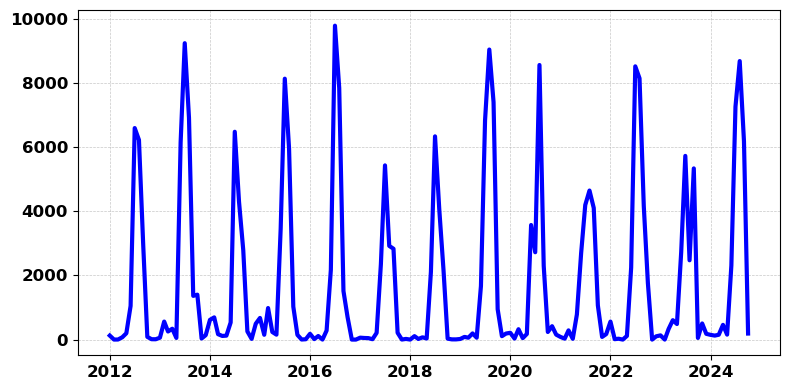

In [70]:
prec_data["SUM_PRECTOTCORR"] = prec_data.iloc[:, 1:].sum(axis=1) # sum of precipitation across all districts

plt.figure(figsize=(8, 4))

plt.plot(prec_data['Price Date'], prec_data['SUM_PRECTOTCORR'], color="blue", linewidth=3)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Prec-MP-Statelevel.png", dpi=600, bbox_inches='tight')
plt.show()

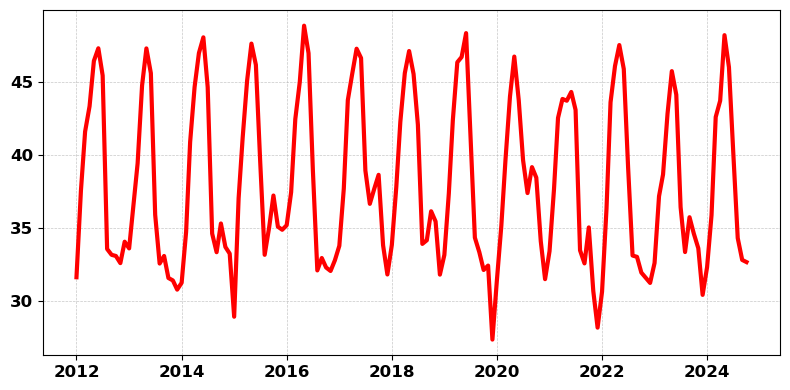

In [71]:
tmax_data["MAX_T2M_MAX"] = tmax_data.iloc[:, 1:].max(axis=1) # maximum temperature across all districts

plt.figure(figsize=(8, 4))

plt.plot(tmax_data['Price Date'], tmax_data['MAX_T2M_MAX'], color="red", linewidth=3)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Tmax-MP-Statelevel.png", dpi=600, bbox_inches='tight')
plt.show()

In [72]:
# Optimizing the parameters and showcasing the table of results

params, results = optimize_egarch_parameters(data["State_Mean_LogReturns"].dropna(), p_range=[1, 2, 3], o_range=[1, 2, 3], q_range=[1, 2, 3])
print(f"Best EGARCH parameters: {params}")
print(f"Table of simulated results: \n{results}")

c:\Users\Abbin\miniconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008142. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Abbin\miniconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008142. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Abbin\miniconda3\Lib\site-packages\arch\univariate\base.py:309: DataS

Best EGARCH parameters: {'p': 3, 'o': 3, 'q': 1}
Table of simulated results: 
    p  o  q         AIC
0   3  3  1 -352.718320
1   3  2  1 -351.317597
2   3  2  2 -351.217602
3   1  2  3 -351.163688
4   3  3  2 -351.076688
5   1  2  2 -350.824589
6   1  3  1 -350.500908
7   1  2  1 -350.401553
8   3  2  3 -350.077054
9   1  3  3 -349.617290
10  1  3  2 -349.585976
11  2  2  3 -349.387048
12  2  2  2 -349.178665
13  3  3  3 -349.076689
14  2  3  1 -348.931008
15  2  2  1 -348.567067
16  2  3  3 -347.726729
17  2  3  2 -347.590574
18  3  1  1 -346.878514
19  3  1  2 -344.878514
20  3  1  3 -342.878514
21  1  1  1 -339.985621
22  2  1  1 -337.999378
23  1  1  2 -337.985621
24  2  1  2 -335.999378
25  1  1  3 -335.985621
26  2  1  3 -333.277273


c:\Users\Abbin\miniconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008142. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [73]:
# Fitting the EGARCH model on the modal price log returns

model = arch_model(data["State_Mean_LogReturns"].dropna(), vol='EGARCH', p=params['p'], o=params['o'], q=params['q'], rescale=False)
garch_fit = model.fit(disp='off')
print(garch_fit.summary())

                       Constant Mean - EGARCH Model Results                      
Dep. Variable:     State_Mean_LogReturns   R-squared:                       0.000
Mean Model:                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        EGARCH   Log-Likelihood:                185.359
Distribution:                     Normal   AIC:                          -352.718
Method:               Maximum Likelihood   BIC:                          -325.444
                                           No. Observations:                  153
Date:                   Fri, Oct 17 2025   Df Residuals:                      152
Time:                           01:36:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.7740e-03  6.181

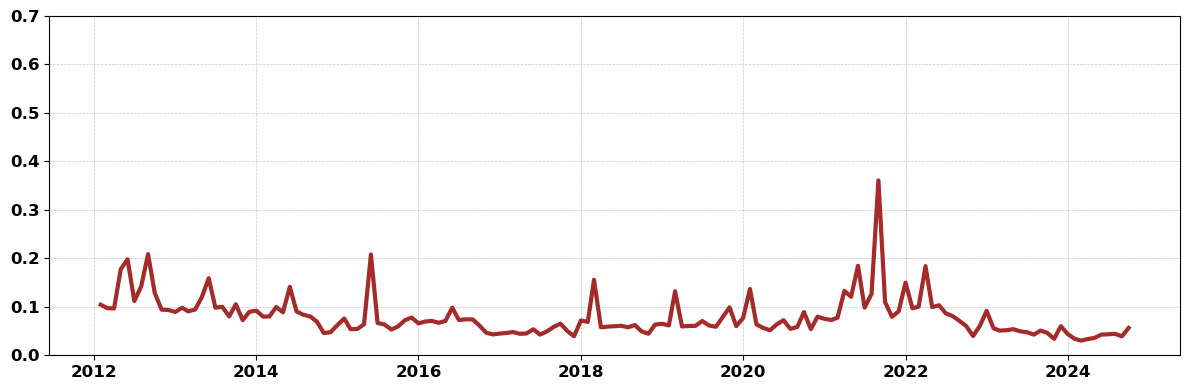

In [74]:
# Plotting the conditional volatility obtained from EGARCH

data["State_Mean_LogReturns_CondVol"] = garch_fit.conditional_volatility

plt.figure(figsize=(12, 4))

plt.plot(data["Price Date"], data["State_Mean_LogReturns_CondVol"], color="brown", linewidth=3)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(0, 0.7)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Soybean-condvol-MP.png", dpi=600, bbox_inches='tight')
plt.show()

In [75]:
df = pd.DataFrame() # Preparing dataframe for modelling
df["Price Date"] = data["Price Date"].iloc[1:]
df["Price Date"] = pd.to_datetime(df["Price Date"], format="%d-%m-%Y")

df["cond_vol"] = data["State_Mean_LogReturns_CondVol"].iloc[1:] # Dependent variable
df["PREC"] = prec_data["SUM_PRECTOTCORR"].iloc[1:] # independent variable
df["MAXTEMP"] = tmax_data["MAX_T2M_MAX"].iloc[1:] # independent variable

Cross-Correlation: Volatility vs Max Temperature


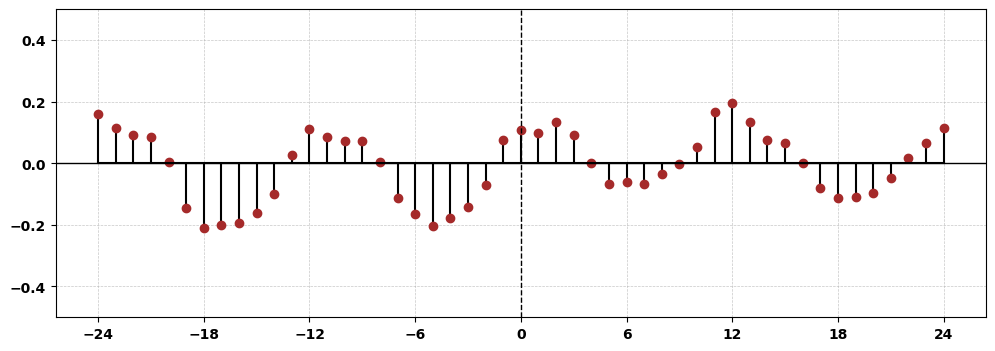

Cross-Correlation: Volatility vs Precipitation


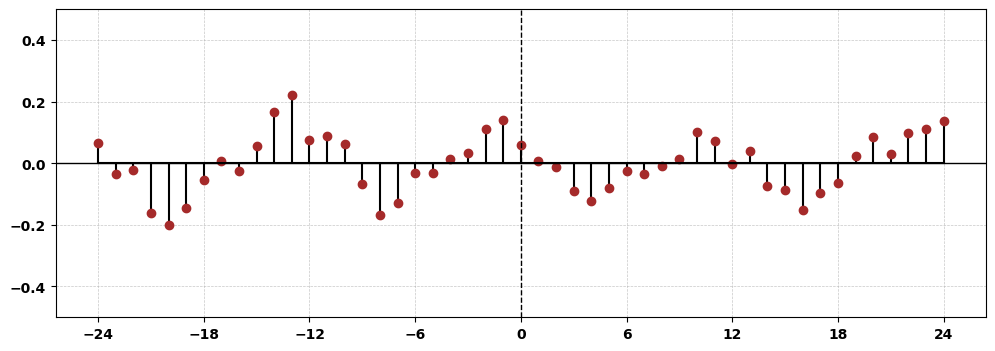


Granger Causality Test: MAXTEMP -> cond_vol

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5000  , p=0.4806  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=0.5101  , p=0.4751  , df=1
likelihood ratio test: chi2=0.5092  , p=0.4755  , df=1
parameter F test:         F=0.5000  , p=0.4806  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6890  , p=0.5037  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=1.4252  , p=0.4904  , df=2
likelihood ratio test: chi2=1.4185  , p=0.4920  , df=2
parameter F test:         F=0.6890  , p=0.5037  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7533  , p=0.5222  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=2.3706  , p=0.4991  , df=3
likelihood ratio test: chi2=2.3520  , p=0.5026  , df=3
parameter F test:         F=0.7533  , p=0.5222  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr

{np.int64(1): ({'ssr_ftest': (np.float64(0.0713002430938698),
    np.float64(0.7898221668688612),
    np.float64(149.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.07273581845817591),
    np.float64(0.787394300646319),
    np.int64(1)),
   'lrtest': (np.float64(0.07271842104978532),
    np.float64(0.7874191179124181),
    np.int64(1)),
   'params_ftest': (np.float64(0.07130024309389904),
    np.float64(0.7898221668688136),
    np.float64(149.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.13968867215528916),
    np.float64(0.8697450187075115),
    np.float64(146.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.28894506158148847),
    np.float64(0.8654786860917179),
    np.int64(2)),
   'lrtest': (np.float64(0.2886689592822904),
    np.float64(0.8655981746668641),
    np.int64(2)),
   'params_ftest': (np.float64(0.13968867215997352),
    np.float64(0.8697450187034437),
    np.float64(146.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
 

In [76]:
# Conduct cross-correlation analysis
print("Cross-Correlation: Volatility vs Max Temperature")
cc_temp = cross_correlation_analysis(df['cond_vol'], df['MAXTEMP'])

print("Cross-Correlation: Volatility vs Precipitation")
cc_prec = cross_correlation_analysis(df['cond_vol'], df['PREC'])

# Conduct granger causality test
granger_causality_test(df, 'MAXTEMP', 'cond_vol') 
granger_causality_test(df, 'PREC', 'cond_vol')

## Modelling : SARIMAX and LSTM

### SARIMAX Model for test prediction

In [77]:
# Training - test split for SARIMAX: 65% - 35%
train = df[ : int(0.65*len(df))]
train["Price Date"] = pd.to_datetime(train["Price Date"], format="%d-%m-%Y")

test = df[int(0.65*len(df)) : ]
test["Price Date"] = pd.to_datetime(test["Price Date"], format="%d-%m-%Y")

C:\Users\Abbin\AppData\Local\Temp\ipykernel_3984\2211875968.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Price Date"] = pd.to_datetime(train["Price Date"], format="%d-%m-%Y")
C:\Users\Abbin\AppData\Local\Temp\ipykernel_3984\2211875968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Price Date"] = pd.to_datetime(test["Price Date"], format="%d-%m-%Y")


In [78]:
best_params = auto_arima(train["cond_vol"], exog=train[["PREC", "MAXTEMP"]],
                         p_range=(0,3), d_range=(0,1), q_range=(0,3),
                         P_range=(0,2), D_range=(0,1), Q_range=(0,2),
                         s=12, criterion="aic")

print("Best SARIMAX Order:", best_params["best_order"])
print("Best Seasonal Order:", best_params["best_seasonal_order"])
print("Best AIC:", best_params["best_aic"])
print("Table of simulated results:\n", best_params["results_table"])

c:\Users\Abbin\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Abbin\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Abbin\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Abbin\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Abbin\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: M

Best SARIMAX Order: (1, 0, 1)
Best Seasonal Order: (0, 0, 0, 12)
Best AIC: -396.82883938521735
Table of simulated results:
          order seasonal_order          aic
0    (1, 0, 1)  (0, 0, 0, 12)  -396.828839
1    (1, 0, 0)  (0, 0, 0, 12)  -395.993787
2    (1, 0, 2)  (0, 0, 0, 12)  -395.015136
3    (2, 0, 0)  (0, 0, 0, 12)  -391.637337
4    (0, 1, 2)  (0, 0, 0, 12)  -391.586469
..         ...            ...          ...
571  (2, 1, 1)  (1, 1, 2, 12)  3248.085202
572  (3, 1, 1)  (1, 1, 2, 12)  3249.828338
573  (3, 1, 0)  (1, 1, 2, 12)  3297.161436
574  (2, 1, 0)  (1, 1, 2, 12)  3307.397330
575  (1, 1, 0)  (1, 1, 2, 12)  3310.939266

[576 rows x 3 columns]


c:\Users\Abbin\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [79]:
# Fitting the SARIMAX model on the conditional volatility

sarimax_model = SARIMAX(train["cond_vol"], order=best_params["best_order"], seasonal_order=best_params["best_seasonal_order"], exog=train[["PREC", "MAXTEMP"]])
sarimax_fit = sarimax_model.fit()
print(sarimax_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               cond_vol   No. Observations:                   99
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 207.926
Date:                Fri, 17 Oct 2025   AIC                           -405.851
Time:                        01:55:25   BIC                           -392.876
Sample:                             0   HQIC                          -400.601
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PREC        5.404e-07   1.46e-06      0.371      0.711   -2.32e-06     3.4e-06
MAXTEMP        0.0020      0.000      7.476      0.000       0.001       0.003
ar.L1          0.8489      0.101      8.366      0.0

c:\Users\Abbin\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


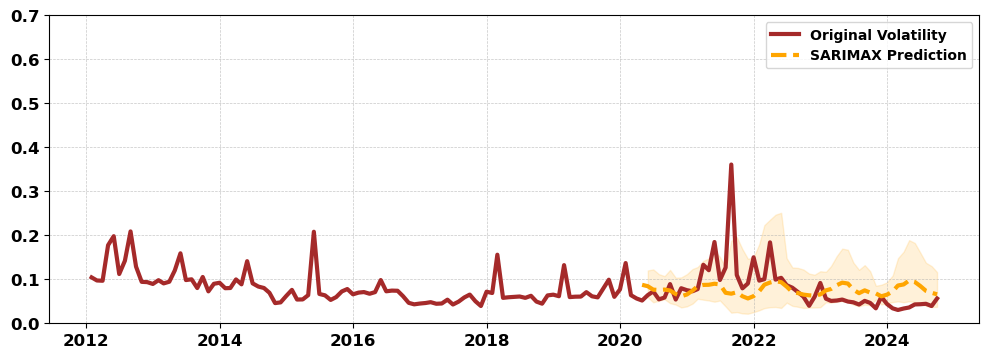

MAPE (test): 0.47606354727624406


In [80]:
# Plotting the SARIMAX forecast with 95% confidence interval

sarimax_forecast = sarimax_fit.predict(start=len(train), end=len(df)-1, exog=test[["PREC", "MAXTEMP"]])

log_residuals = np.log(test["cond_vol"]) - np.log(sarimax_forecast)
rolling_std = log_residuals.rolling(window=10, min_periods=1).std().shift(0)

upper_bound_arimax = sarimax_forecast * np.exp(2 * rolling_std)
lower_bound_arimax = sarimax_forecast * np.exp(-2 * rolling_std)

plt.figure(figsize=(12, 4))

plt.plot(df["Price Date"], df["cond_vol"], color='brown', label="Original Volatility", linewidth=3)
plt.plot(test["Price Date"], sarimax_forecast, color='orange', linestyle="--", label="SARIMAX Prediction", linewidth=3)
plt.fill_between(test["Price Date"], lower_bound_arimax, upper_bound_arimax, color='orange', alpha=0.15)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(0, 0.7)
plt.legend(fontsize=12, prop={'weight': 'bold'})
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig("images/Soybean-sarimax-Statelevel.png", dpi=600, bbox_inches='tight')
plt.show()

mape = mean_absolute_percentage_error(test["cond_vol"], sarimax_forecast)
print(f"MAPE (test): {mape}")

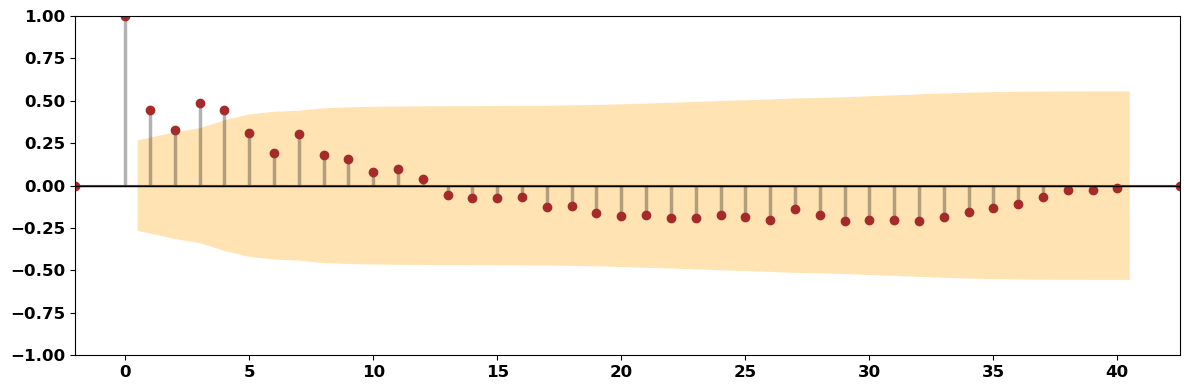

In [81]:
# Plotting ACF of SARIMAX residuals for test data

residuals = test["cond_vol"] - sarimax_forecast

fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(residuals, lags=40, alpha=0.05, ax=ax, marker="o", title="", markersize=6, vlines_kwargs={"colors": "black", "linewidth": 2.5})

for line in ax.get_lines():
    line.set_color("brown")

for polygon in ax.collections:
    polygon.set_facecolor("orange")
    polygon.set_alpha(0.3)

ax.axhline(0, color="black", linewidth=1)
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("images/Soybean-sarimax-ACF.png", dpi=600, bbox_inches='tight')
plt.show()

### LSTM Model for test prediction

In [ ]:
# Function to create sequences for LSTM model
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Function to optimize LSTM parameters using Optuna
def objective(trial):
    seq_length = trial.suggest_int("seq_length", 12, 36, step=6)
    train_ratio = trial.suggest_float("train_ratio", 0.5, 0.8, step=0.1)
    num_lstm_layers = trial.suggest_int("num_lstm_layers", 1, 3)
    lstm_units = trial.suggest_int("lstm_units", 32, 128, step=16)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    epochs = trial.suggest_int("epochs", 50, 500, step=50)
    
    X = df[["PREC", "MAXTEMP"]].values
    y = df[["cond_vol"]].values

    x_scaler, y_scaler = StandardScaler(), StandardScaler()
    X_scaled = x_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))
    
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)
    train_size = int(train_ratio * len(X_seq))
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]
    
    model = Sequential()
    for _ in range(num_lstm_layers - 1):
        model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
    model.add(LSTM(units=lstm_units))
    model.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred_scaled = model.predict(X_test)
    y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    return mean_absolute_percentage_error(y_test_inv, y_pred_inv)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

In [83]:
best_params = {'seq_length': 36, 'train_ratio': 0.55, 'num_lstm_layers': 3, 'lstm_units': 64, 'batch_size': 64, 'learning_rate': 0.002531376077240718, 'epochs': 100} # Optimised parameters
best_params["train_ratio"] = 0.54 # Same testing period as in SARIMAX

X = df[["PREC", "MAXTEMP"]].values # independent variables
y = df[["cond_vol"]].values # dependent variable

# Standardizing the data
x_scaler, y_scaler = StandardScaler(), StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

# Creating sequences and splitting train - test: 60% - 40%
seq_length = best_params['seq_length']
train_ratio = best_params['train_ratio']
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

train_size = int(train_ratio * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [ ]:
# Build LSTM Model
model = Sequential()
for _ in range(best_params['num_lstm_layers'] - 1):
    model.add(LSTM(units=best_params['lstm_units'], return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(LSTM(units=best_params['lstm_units']))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Saving the best LSTM model
checkpoint_path = "MP_Soybean_Best_Weights_LSTM.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params["batch_size"], verbose=1, callbacks=[checkpoint])

model.save("MP_Soybean_Best_Model_LSTM.h5")
print("Best model saved successfully!")

In [85]:
# Loading the best LSTM model and predicting for test data

model = load_model("MP_Soybean_Best_Model_LSTM.h5")
print("Best model loaded successfully!")

y_pred_scaled = model.predict(X_test)

y_train_inv = y_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

mape_test = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("Actual yield:", y_test_inv.flatten())
print("Predicted Yield: ", y_pred_inv.flatten())
print(f"MAPE (Test): {mape_test:.2f}%")

Best model loaded successfully!


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000019ABA9765C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Actual yield: [0.05167442 0.06395712 0.07234129 0.05433676 0.05852489 0.08906346
 0.0539552  0.07959822 0.07521361 0.07277727 0.07764827 0.13288802
 0.12063413 0.18467364 0.09831124 0.12661572 0.36079373 0.10982949
 0.07939863 0.09055188 0.14998226 0.09692133 0.10021254 0.18386487
 0.09921169 0.10328208 0.08655877 0.0808541  0.07091508 0.06035781
 0.03974711 0.06025136 0.09163629 0.05582655 0.05085751 0.05173353
 0.05388246 0.04940141 0.04762738 0.04263956 0.05090235 0.04625419
 0.03397097 0.06004315 0.04383546 0.03393727 0.0302522  0.03355112
 0.03589726 0.04282084 0.0432928  0.04427816 0.0391511  0.05631609]
Predicted Yield:  [0.04592795 0.04350831 0.04430752 0.04908897 0.0510029  0.05278437
 0.05075825 0.04806906 0.04678545 0.04696986 0.04806065 0.05021766
 0.05360889 0.05842607 0.05813263 0.04918294 0.05118868 0.05423773
 0.0585447  0.06401556 0.0700648  0.07445508 0.07799167 0.08197148
 0.08643118 0.09142293 0.0901093  0.06753664 0.0621223  0

In [86]:
# Plotting the LSTM forecast with 95% confidence interval

y_test_inv = y_test_inv.flatten()
y_pred_inv = y_pred_inv.flatten()

log_residuals = pd.Series(np.log(y_test_inv) - np.log(y_pred_inv))
rolling_std = log_residuals.rolling(window=10, min_periods=1).std()

upper_bound_lstm = y_pred_inv * np.exp(2 * rolling_std)
lower_bound_lstm = y_pred_inv * np.exp(-2 * rolling_std)

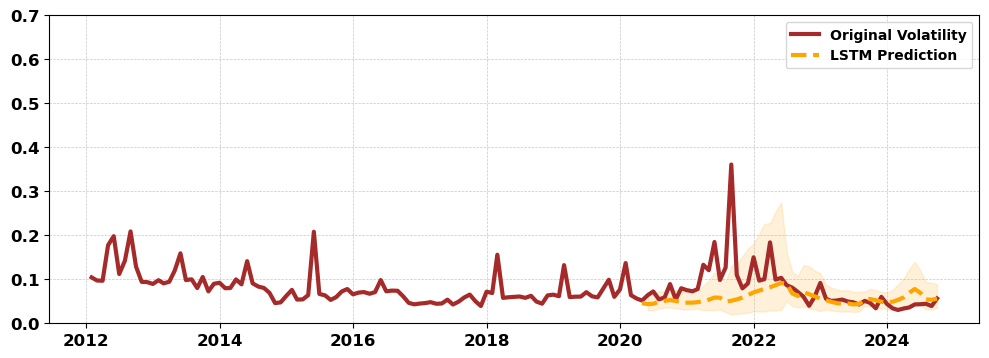

In [87]:
plt.figure(figsize=(12, 4))

price_dates = df["Price Date"].iloc[-len(y_test_inv):].values
price_dates = pd.to_datetime(price_dates, format="%d-%m-%Y")

plt.plot(df["Price Date"], df["cond_vol"], label="Original Volatility", color="brown", linewidth=3)
plt.plot(price_dates, y_pred_inv, label="LSTM Prediction", color='orange', linestyle="dashed", linewidth=3)
plt.fill_between(price_dates, upper_bound_lstm, lower_bound_lstm, color='orange', alpha=0.15)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(0, 0.7)
plt.legend(fontsize=12, prop={'weight': 'bold'})
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig("images/Soybean-lstm-Statelevel.png", dpi=600, bbox_inches='tight')
plt.show()

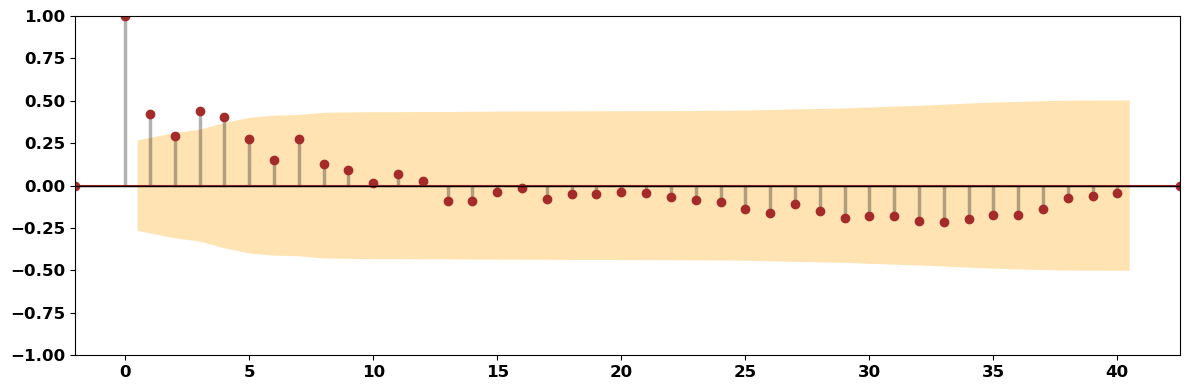

In [88]:
# Plotting ACF of LSTM residuals for test data

residuals = pd.Series(y_test_inv - y_pred_inv)

fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(residuals, lags=40, alpha=0.05, ax=ax, marker="o", title="", markersize=6, vlines_kwargs={"colors": "black", "linewidth": 2.5})

for line in ax.get_lines():
    line.set_color("brown")

for polygon in ax.collections:
    polygon.set_facecolor("orange")
    polygon.set_alpha(0.3)

ax.axhline(0, color="black", linewidth=1)
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("images/Soybean-lstm-ACF.png", dpi=600, bbox_inches='tight')
plt.show()